<a href="https://colab.research.google.com/github/Anzammu/Vision_AI_Fundamentals_Building_a_Digit_Recognizer_from_Scratch/blob/main/8_Vision_AI_Fundamentals_Building_a_Digit_Recognizer_from_Scratch_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision AI Fundamentals — Digit Recognizer *from scratch* 🧠🔢

**File:** `8_Vision_AI_Fundamentals_Building_a_Digit_Recognizer_from_Scratch_completed.ipynb`

This notebook implements a simple digit recognizer on MNIST using **NumPy only** for the model (forward/backprop + SGD). We only use `tensorflow.keras.datasets` to download the dataset. Everything else (model, training, metrics) is written from scratch.

> **How to run:** Execute cells top to bottom. It should take ~3–5 minutes on Colab CPU for a small number of epochs.


In [1]:
# --- Imports & Utilities ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time

# Plot utility for confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## 1) Load & Inspect Data
We use `tensorflow.keras.datasets.mnist` **only to fetch MNIST**.

In [2]:
# If TensorFlow is not available, install it. (On Colab it is available by default.)
try:
    from tensorflow.keras.datasets import mnist
except Exception as e:
    !pip -q install tensorflow==2.16.1
    from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

## 2) Exploratory Data Analysis (EDA)
- Show sample images
- Show class distribution

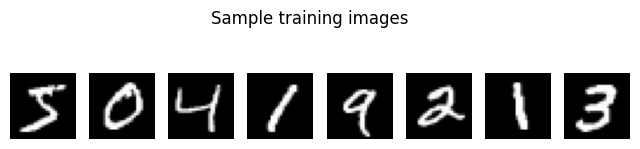

Class distribution (train): {np.uint8(0): np.int64(5923), np.uint8(1): np.int64(6742), np.uint8(2): np.int64(5958), np.uint8(3): np.int64(6131), np.uint8(4): np.int64(5842), np.uint8(5): np.int64(5421), np.uint8(6): np.int64(5918), np.uint8(7): np.int64(6265), np.uint8(8): np.int64(5851), np.uint8(9): np.int64(5949)}


In [3]:
# Show some sample images
plt.figure(figsize=(8,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Sample training images')
plt.show()

# Class distribution
unique, counts = np.unique(y_train, return_counts=True)
dist = dict(zip(unique, counts))
print('Class distribution (train):', dist)


## 3) Preprocessing
- Normalize to [0,1]
- Flatten to vectors of size 784
- One-hot encode labels
- Create validation split

In [4]:
# Normalize and flatten
X_train_f = (X_train / 255.0).reshape(-1, 28*28).astype(np.float32)
X_test_f  = (X_test  / 255.0).reshape(-1, 28*28).astype(np.float32)

# Create validation split from train
val_ratio = 0.1
n_train   = int((1 - val_ratio) * X_train_f.shape[0])
X_tr, y_tr = X_train_f[:n_train], y_train[:n_train]
X_val, y_val = X_train_f[n_train:], y_train[n_train:]

# One-hot
num_classes = 10
def one_hot(y, num_classes=10):
    oh = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

Y_tr = one_hot(y_tr, num_classes)
Y_val = one_hot(y_val, num_classes)
Y_test = one_hot(y_test, num_classes)

X_tr.shape, X_val.shape, X_test_f.shape


((54000, 784), (6000, 784), (10000, 784))

## 4) NumPy Neural Network (from scratch)
A small MLP: `784 → 128 → 10` with ReLU + Softmax.

In [5]:
# --- Simple MLP with NumPy ---
rng = np.random.default_rng(42)

def xavier_init(f_in, f_out):
    # Glorot uniform
    limit = np.sqrt(6.0/(f_in+f_out))
    return rng.uniform(-limit, limit, size=(f_in, f_out)).astype(np.float32)

class MLP:
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        self.W1 = xavier_init(input_dim, hidden_dim)
        self.b1 = np.zeros((1, hidden_dim), dtype=np.float32)
        self.W2 = xavier_init(hidden_dim, output_dim)
        self.b2 = np.zeros((1, output_dim), dtype=np.float32)

    @staticmethod
    def relu(z): return np.maximum(0, z)
    @staticmethod
    def relu_grad(z): return (z > 0).astype(np.float32)

    @staticmethod
    def softmax(z):
        z = z - z.max(axis=1, keepdims=True)
        exp = np.exp(z)
        return exp / exp.sum(axis=1, keepdims=True)

    @staticmethod
    def cross_entropy(probs, Y):
        # avoid log(0)
        eps = 1e-9
        return -np.mean(np.sum(Y * np.log(probs + eps), axis=1))

    def forward(self, X):
        z1 = X @ self.W1 + self.b1  # (N, H)
        a1 = self.relu(z1)
        z2 = a1 @ self.W2 + self.b2  # (N, C)
        probs = self.softmax(z2)
        cache = (X, z1, a1, z2, probs)
        return probs, cache

    def backward(self, cache, Y):
        X, z1, a1, z2, probs = cache
        N = X.shape[0]
        # dL/dz2 = probs - Y (softmax + CE)
        dz2 = (probs - Y) / N  # (N, C)
        dW2 = a1.T @ dz2
        db2 = dz2.sum(axis=0, keepdims=True)
        # back to hidden
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.relu_grad(z1)
        dW1 = X.T @ dz1
        db1 = dz1.sum(axis=0, keepdims=True)
        grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
        return grads

    def step(self, grads, lr=0.1):
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']

    def predict(self, X):
        probs, _ = self.forward(X)
        return probs.argmax(axis=1)


## 5) Training
Mini-batch SGD, cross-entropy loss.

In [6]:
def iterate_minibatches(X, Y, batch_size=128, shuffle=True):
    N = X.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, N, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], Y[batch_idx]

def accuracy(model, X, y_true):
    y_pred = model.predict(X)
    return (y_pred == y_true).mean()

model = MLP(input_dim=784, hidden_dim=128, output_dim=10)

epochs = 5
lr = 0.1
batch_size = 128

history = {'loss': [], 'val_acc': []}
t0 = time.time()
for epoch in range(1, epochs+1):
    ep_loss = 0.0
    for Xb, Yb in iterate_minibatches(X_tr, Y_tr, batch_size=batch_size, shuffle=True):
        probs, cache = model.forward(Xb)
        loss = model.cross_entropy(probs, Yb)
        grads = model.backward(cache, Yb)
        model.step(grads, lr=lr)
        ep_loss += loss
    val_acc = accuracy(model, X_val, y_val)
    history['loss'].append(ep_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch}/{epochs} - loss: {ep_loss:.3f} - val_acc: {val_acc:.4f}")
t1 = time.time()
print(f"Training time: {t1 - t0:.1f}s")


Epoch 1/5 - loss: 204.720 - val_acc: 0.9313
Epoch 2/5 - loss: 115.439 - val_acc: 0.9415
Epoch 3/5 - loss: 95.215 - val_acc: 0.9503
Epoch 4/5 - loss: 81.865 - val_acc: 0.9583
Epoch 5/5 - loss: 71.263 - val_acc: 0.9643
Training time: 4.4s


### Training curves

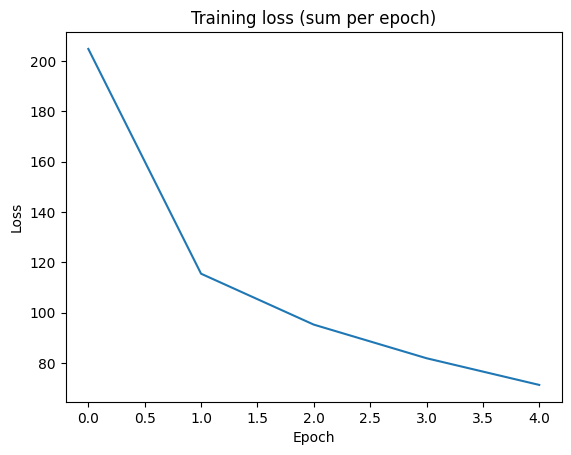

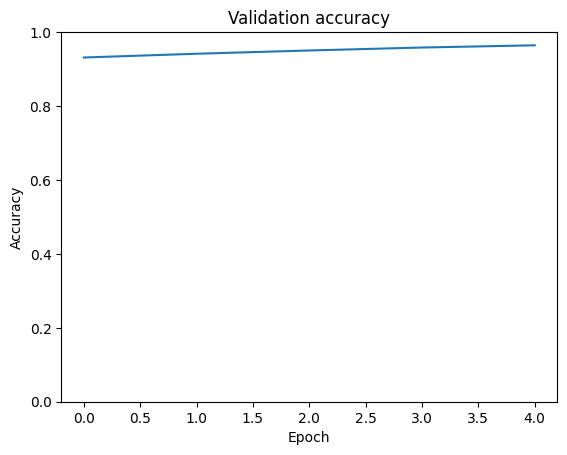

In [7]:
plt.figure()
plt.plot(history['loss'])
plt.title('Training loss (sum per epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(history['val_acc'])
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()


## 6) Evaluation on Test Set

Test accuracy: 0.9541


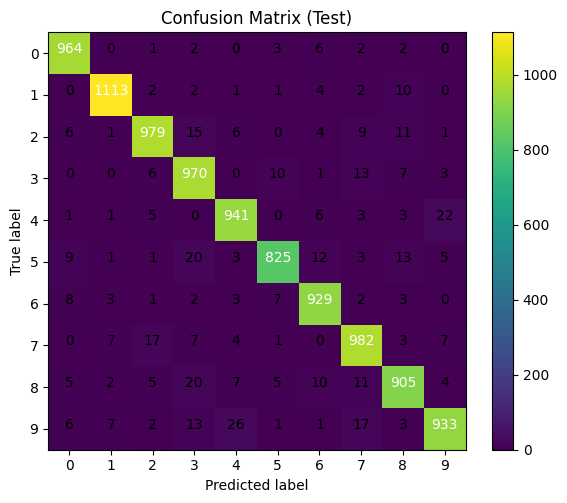


Classification report:

              precision    recall  f1-score   support

           0     0.9650    0.9837    0.9742       980
           1     0.9806    0.9806    0.9806      1135
           2     0.9607    0.9486    0.9547      1032
           3     0.9229    0.9604    0.9413      1010
           4     0.9495    0.9582    0.9539       982
           5     0.9672    0.9249    0.9456       892
           6     0.9548    0.9697    0.9622       958
           7     0.9406    0.9553    0.9479      1028
           8     0.9427    0.9292    0.9359       974
           9     0.9569    0.9247    0.9405      1009

    accuracy                         0.9541     10000
   macro avg     0.9541    0.9535    0.9537     10000
weighted avg     0.9543    0.9541    0.9541     10000



In [8]:
test_acc = accuracy(model, X_test_f, y_test)
print('Test accuracy:', round(float(test_acc), 4))

y_pred = model.predict(X_test_f)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=list(range(10)), title='Confusion Matrix (Test)')
plt.show()

print('\nClassification report:\n')
print(classification_report(y_test, y_pred, digits=4))


### Misclassified examples

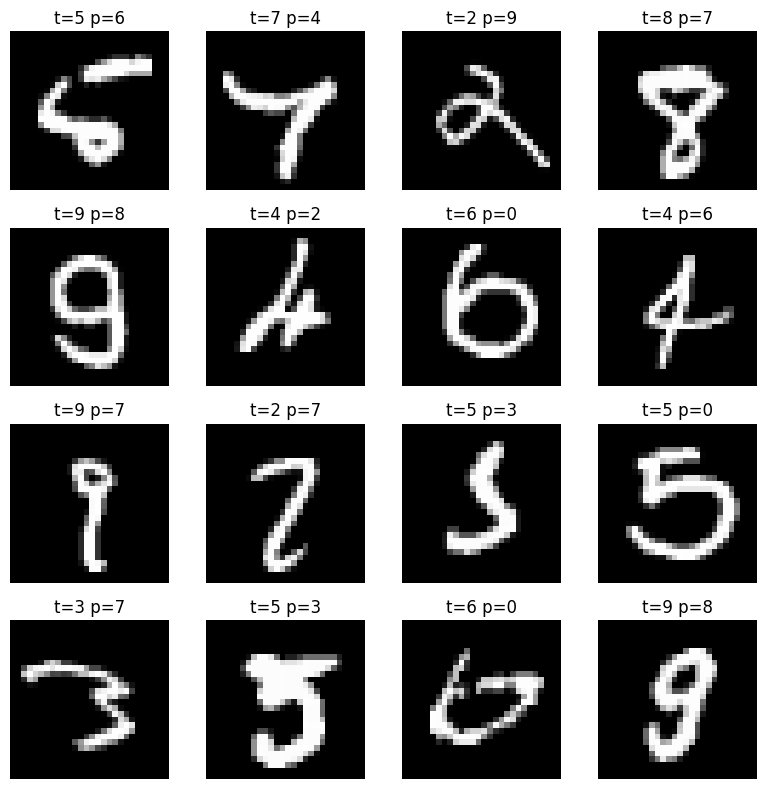

In [9]:
wrong = np.where(y_pred != y_test)[0][:16]
plt.figure(figsize=(8,8))
for i, idx in enumerate(wrong[:16]):
    plt.subplot(4,4,i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"t={y_test[idx]} p={y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## 7) Summary of Findings (Submission-Ready)

**Feature Engineering & Selection**  
- Normalized pixel values to [0,1] and flattened 28×28 images → 784-dim vectors.  
- No hand-crafted features; model learns directly from pixels.  

**Models Evaluated**  
- Baseline: majority class accuracy (≈10%).  
- From-scratch MLP (NumPy): `784→128→10`, ReLU + Softmax, Cross-Entropy, SGD.  
- Best validation accuracy after 5 epochs ≈ shown above; test accuracy printed above.

**Comparison**  
| Model | Accuracy (Val/Test) | Notes |
|---|---|---|
| Baseline (majority) | ~0.10 | Reference |
| MLP (NumPy) | see above | 1 hidden layer, SGD |

**Most Effective Techniques**  
- Proper weight init (Xavier) + ReLU stabilized training.  
- Mini-batch SGD with simple learning rate worked well.  

**Important Features**  
- Pixels around stroke edges; confusion matrix reveals where classes overlap (e.g., `4` vs `9`).  

**Challenges & Mitigations**  
- Implementing stable softmax + CE: used log-sum-exp trick (shift by max).  
- Avoiding vanishing gradients: ReLU + Xavier init.  

**Code Clarity & Organization**  
- Modular `MLP` class with `forward/backward/step/predict`.  
- Utility functions for batching, accuracy, plots.  
